# Import Packages

In [48]:
import itertools
import os
from pathlib import Path
import subprocess
import sys

from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from feature_functions import *

# Load E. coli K-12 MG1655 Bitome

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [3]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)

In [4]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    origin=origin, terminus=terminus,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# Load Multi-Strain Bitomes

## Load Bitome Objects

In [5]:
bitomes_by_id = {}

genome_dir = Path('..', 'data', 'e_coli_genomes', 'refseq')

for file in os.listdir(genome_dir):
    gb_id = file.split('.')[0]
    bitome = Bitome(Path(genome_dir, file))
    bitomes_by_id[bitome.reference_id] = bitome

## Hard-Code Short Names

In [6]:
[(b.description, b.reference_id) for b in bitomes_by_id.values()]

[('Escherichia coli CFT073, complete genome', 'NC_004431.1'),
 ('Escherichia coli 042 complete genome', 'NC_017626.1'),
 ('Escherichia coli str. K-12 substr. W3110 DNA, complete genome',
  'NC_007779.1'),
 ('Escherichia coli O157:H7 str. Sakai, complete genome', 'NC_002695.1'),
 ('Escherichia coli ATCC 8739, complete genome', 'NC_010468.1'),
 ('Escherichia coli KO11FL, complete genome', 'NC_017660.1'),
 ('Escherichia coli BL21(DE3), complete genome', 'NC_012971.2'),
 ('Escherichia coli W, complete genome', 'NC_017635.1')]

In [7]:
id_to_name = {
    'NC_004431.1': 'CFT073',
    'NC_017626.1': '042',
    'NC_007779.1': 'W3110',
    'NC_002695.1': 'O157:H7',
    'NC_010468.1': 'Crooks',
    'NC_017660.1': 'KO11FL',
    'NC_012971.2': 'BL21',
    'NC_017635.1': 'W'
}

## Write BLAST Databases

In [8]:
BLAST_PATH = Path('../data/multi_strain_blast/')

In [9]:
for org_id, bitome in bitomes_by_id.items():

    with open(Path(BLAST_PATH, f'{org_id}.fasta'), 'w') as file_out:
        SeqIO.write(bitome.reference_record, file_out, 'fasta')
    
    # make the blast db
    subprocess.check_output(['makeblastdb', '-in', Path(BLAST_PATH, f'{org_id}.fasta'), 
                            '-out', Path(BLAST_PATH, org_id), '-parse_seqids', '-dbtype', 'nucl'])

## Prepare FASTA of MG1655 TUs

In [10]:
with open(Path(BLAST_PATH, 'mg1655_tus.fasta'), 'w') as file_out:
    
    clean_tu_table = mg1655.tu_table[(mg1655.tu_table['left'].notna()) & (mg1655.tu_table['right'].notna()) & 
                                    (mg1655.tu_table['strand'].notna()) & mg1655.tu_table['tss'].notna()]
    
    for tu_row in clean_tu_table.itertuples():
        tu_seq = str(mg1655.get_sequence(tu_row.left, tu_row.right, tu_row.strand))
        file_out.write(f'>{tu_row.Index}\n{tu_seq}\n')

## BLAST for MG1655 TUs in Multi-Strains

In [11]:
column_names = [
    'mg_tu_id', 'strain_id', 'percent', 'align_length', 'n_mismatch', 'n_gapopen',
    'mg_start', 'mg_end', 'strain_start', 'strain_end', 'e_value', 'bit_score'
]

In [12]:
for strain_id, bitome in bitomes_by_id.items():
    
    # run the blast query
    subprocess.check_output(['blastn',
                             '-db', Path(BLAST_PATH, strain_id),
                             '-query', Path(BLAST_PATH, 'mg1655_tus.fasta'),
                             '-out', Path(BLAST_PATH, f'{strain_id}.csv'),
                             '-evalue', '0.001',
                             '-outfmt', '10',
                             '-num_threads', '4'])

In [13]:
multi_strain_tu_rows = []

for strain_id, bitome in bitomes_by_id.items():
    
    # read in the file, add column names
    blast_report_df = pd.read_csv(Path(BLAST_PATH, f'{strain_id}.csv'), header=0, names=column_names)
    
    # move through and only keep the best match by TU
    for tu_id, tu_blast_df in blast_report_df.groupby('mg_tu_id'):
     
        mg_tu_info = mg1655.tu_table[mg1655.tu_table.index == tu_id][[
            'left', 'right', 'strand', 'tss']].drop_duplicates().T.squeeze()
        mg_tu_len = int(mg_tu_info['right'] - mg_tu_info['left'] + 1)
        
        if pd.isna(mg_tu_info['tss']):
            if mg_tu_info['strand'] == 1:
                mg_tss = mg_tu_info['left']
            else:
                mg_tss = mg_tu_info['right']
        else:
            mg_tss = int(mg_tu_info['tss'])
        
        # best match starts at the same point as the MG TU
        matches_from_start = tu_blast_df[(tu_blast_df['mg_start'] == 1) &
                                        (tu_blast_df['mg_end'] == mg_tu_len)]
        matches_from_start = matches_from_start.sort_values(by='mg_end', ascending=False)
        if not matches_from_start.empty:
            strain_start, strain_end = matches_from_start.iloc[0, :][['strain_start', 'strain_end']].values
            if strain_start < strain_end:
                strain_tss = strain_start
                strain_strand = 1
            else:
                strain_tss = strain_end
                strain_strand = -1
            
            tu_match_row = [matches_from_start.iloc[0, :]['mg_tu_id'], mg_tss,
                            int(mg_tu_info['strand']),
                           strain_id, strain_tss, strain_strand]
            multi_strain_tu_rows.append(tu_match_row)
    
multi_strain_tu_df = pd.DataFrame(multi_strain_tu_rows, 
                                  columns=['mg_tu_id', 'mg_tss', 'mg_tss_strand',
                                           'strain_id', 'strain_tss', 'strain_tss_strand'])

# Load TFBS Motifs

In [14]:
# modify legacy PSSM format into Bitome 2 format
tf_pwm_db = rpwm('../data/motif_pwm_db.txt')

for tf, pwm in tf_pwm_db.items():
    tf_pwm_db[tf] = {base: [pos_dict[base] for pos_dict in pwm] for base in 'ATCG'}

# Define TFs of Interest

In [15]:
tfs_of_interest = ['Fur', 'Cra', 'PurR']

# Compare TFBS Sequences across Strains

## For Each MG1655 TU, Find TFBS of Interest in Range

In [16]:
TFBS_TSS_UP = 150
TFBS_TSS_DOWN = 50

In [17]:
tfbs_in_mg_df = mg1655.tfbs_table[(mg1655.tfbs_table['tf'].isin(tfs_of_interest)) & 
                                 (mg1655.tfbs_table['left'].notna()) & 
                                  (mg1655.tfbs_table['left'] != 0)].drop_duplicates()

mg_tu_to_tfbs = {}

for tu_row in clean_tu_table.itertuples():
    
    if tu_row.strand == 1:
        tss_range_left, tss_range_right = tu_row.tss - TFBS_TSS_UP, tu_row.tss + TFBS_TSS_DOWN
    else:
        tss_range_left, tss_range_right = tu_row.tss - TFBS_TSS_DOWN, tu_row.tss + TFBS_TSS_UP

    tfbs_near_tu = tfbs_in_mg_df[((tfbs_in_mg_df['left'] > tss_range_left) &
                                 (tfbs_in_mg_df['left'] < tss_range_right)) |
                                ((tfbs_in_mg_df['right'] > tss_range_left) &
                                 (tfbs_in_mg_df['right'] < tss_range_right))]
    if not tfbs_near_tu.empty:
        mg_tu_to_tfbs[tu_row.Index] = tfbs_near_tu

## Look for TFBS Upstream of Multi-Strain TUs

In [63]:
# the distance up and downstream of a RegulonDB motif that we will search (after accounting for if our PSSM
# is not the same length as RegulonDB's site)
TFBS_WIGGLE_DIST = 25

In [64]:
tfbs_multistrain_rows = []

def tfbs_to_tss_dist(tfbs_left, tfbs_right, tss, strand):
    tfbs_center = int((tfbs_right + tfbs_left) / 2)
    if strand == 1:
        dist = tfbs_center - tss
    else:
        dist = tss - tfbs_center
    return dist

mega_clean_tu_table = clean_tu_table[['name', 'strand', 'tss', 'left', 'right']].drop_duplicates()

for mg_tu_id, mg_tu_tfbs_df in tqdm(mg_tu_to_tfbs.items()):
    
    # re-pull the info on this TU
    mg_tu_info = mega_clean_tu_table.loc[mg_tu_id]

    # get all the information for this TU as found in other strains
    strain_tu_df = multi_strain_tu_df[multi_strain_tu_df['mg_tu_id'] == mg_tu_id]
    
    # for each RegulonDB binding site, use the promoter search restricted in that space to find the best motif 
    for mg_tu_tfbs_row in mg_tu_tfbs_df.itertuples():
        
        # get the TF we're 
        tf = mg_tu_tfbs_row.tf
        tf_pssm = tf_pwm_db[tf]
        motif_len = len(tf_pssm['A'])
        rdb_tss_dist = tfbs_to_tss_dist(mg_tu_tfbs_row.left, mg_tu_tfbs_row.right,
                                         mg_tu_info.tss, mg_tu_info.strand)
        
        # record a row for the actual location of this binding site
        rdb_tfbs_row = {
            'mg_tu_id': mg_tu_id,
            'mg_tfbs_id': mg_tu_tfbs_row.Index,
            'strain_id': 'MG1655',
            'tf': tf,
            'tfbs_left': mg_tu_tfbs_row.left,
            'tfbs_right': mg_tu_tfbs_row.right,
            'tfbs_seq': str(mg1655.get_sequence(mg_tu_tfbs_row.left, mg_tu_tfbs_row.right, mg_tu_info.strand)),
            'tfbs_score': None,
            'source': 'RegulonDB',
            'tss_dist': rdb_tss_dist
        }
        tfbs_multistrain_rows.append(rdb_tfbs_row)
        
        # look for the binding site in MG; we can just use the binding sites coordinates since RDB is also MG
        extra_room = int((motif_len - (mg_tu_tfbs_row.right - mg_tu_tfbs_row.left + 1))/2) + TFBS_WIGGLE_DIST
        mg_search = mg1655.motif_search(
            mg_tu_tfbs_row.left - extra_room,
            mg_tu_tfbs_row.right + extra_room,
            mg_tu_info.strand,
            tf_pssm
        ).T.squeeze()
        # record a row for the motif search location of this binding site
        mg_motif_tfbs_row = {
            'mg_tu_id': mg_tu_id,
            'mg_tfbs_id': mg_tu_tfbs_row.Index,
            'strain_id': 'MG1655',
            'tf': tf,
            'tfbs_left': mg_search.left,
            'tfbs_right': mg_search.right,
            'tfbs_seq': mg_search.match_sequence,
            'tfbs_score': mg_search.log_odds,
            'source': 'MotifSearch',
            'tss_dist': tfbs_to_tss_dist(mg_search.left, mg_search.right,
                                         mg_tu_info.tss, mg_tu_info.strand)
        }
        tfbs_multistrain_rows.append(mg_motif_tfbs_row)

        # look for this TFBS in the other strains
        for strain_row in strain_tu_df.itertuples():
            
            if strain_row.strain_tss_strand == 1:
                strain_tfbs_center_expected = strain_row.strain_tss + rdb_tss_dist
            else:
                strain_tfbs_center_expected = strain_row.strain_tss - rdb_tss_dist
            strain_search_left = strain_tfbs_center_expected - int(motif_len/2) - TFBS_WIGGLE_DIST
            strain_search_right = strain_tfbs_center_expected + int(motif_len/2) + TFBS_WIGGLE_DIST

            # perform the motif search in the other strain
            strain_result = bitomes_by_id[strain_row.strain_id].motif_search(
                strain_search_left,
                strain_search_right,
                strain_row.strain_tss_strand,
                tf_pssm
            ).T.squeeze()

            # add the multistrain motif search info to our multistrain info table
            multistrain_row = {
                'mg_tu_id': mg_tu_id,
                'mg_tfbs_id': mg_tu_tfbs_row.Index,
                'strain_id': strain_row.strain_id,
                'tf': tf,
                'tfbs_left': strain_result.left,
                'tfbs_right': strain_result.right,
                'tfbs_seq': strain_result.match_sequence,
                'tfbs_score': strain_result.log_odds,
                'source': 'MotifSearch',
                'tss_dist': tfbs_to_tss_dist(strain_result.left, strain_result.right,
                                             strain_row.strain_tss, strain_row.strain_tss_strand)
            }
            tfbs_multistrain_rows.append(multistrain_row)
    
tfbs_multistrain_df = pd.DataFrame(tfbs_multistrain_rows)
tfbs_multistrain_df['strain_name'] = tfbs_multistrain_df['strain_id'].apply(
    lambda s_id: id_to_name.get(s_id, s_id)
)
tfbs_multistrain_df = tfbs_multistrain_df.drop_duplicates()

In [65]:
tfbs_multistrain_df

,mg_tu_id,mg_tfbs_id,strain_id,tf,tfbs_left,tfbs_right,tfbs_seq,tfbs_score,source,tss_dist,strain_name
0,ECK120008916,ECK120011696,MG1655,Fur,2800586.0,2800604.0,GTAATTTCGACCACTATTT,NaN,RegulonDB,-61.0,MG1655
1,ECK120008916,ECK120011696,MG1655,Fur,2800581.0,2800602.0,CCAGGGTAATTTCGACCACTAT,-2.1,MotifSearch,-65.0,MG1655
2,ECK120008916,ECK120011696,NC_004431.1,Fur,3081123.0,3081144.0,GCGTAATCAATCTAAAATTCCC,-2.4,MotifSearch,-60.0,CFT073
3,ECK120008916,ECK120011696,NC_017626.1,Fur,3062715.0,3062736.0,GCGTAATCAATCTAAAATTCCC,-2.4,MotifSearch,-60.0,042
4,ECK120008916,ECK120011696,NC_007779.1,Fur,2799237.0,2799258.0,CCAGGGTAATTTCGACCACTAT,-2.1,MotifSearch,-65.0,W3110
...,...,...,...,...,...,...,...,...,...,...,...
2333,ECK125203403,ECK125134884,NC_002695.1,Cra,4529470.0,4529490.0,AGCGCAGCAGCCACTAACCCC,-3.9,MotifSearch,-6.0,O157:H7
2334,ECK125203403,ECK125134884,NC_010468.1,Cra,103365.0,103385.0,ACAGCTGAATCGATAAAATAG,14.5,MotifSearch,-9.0,Crooks
2335,ECK125203403,ECK125134884,NC_017660.1,Cra,992490.0,992510.0,ACAGCTGAATCGATAAAATAG,14.5,MotifSearch,-9.0,KO11FL
2336,ECK125203403,ECK125134884,NC_012971.2,Cra,3651839.0,3651859.0,AGCGCAGCAGCCACTAACCCC,-3.9,MotifSearch,-6.0,BL21


# Results

## Overview of TFBS Distances

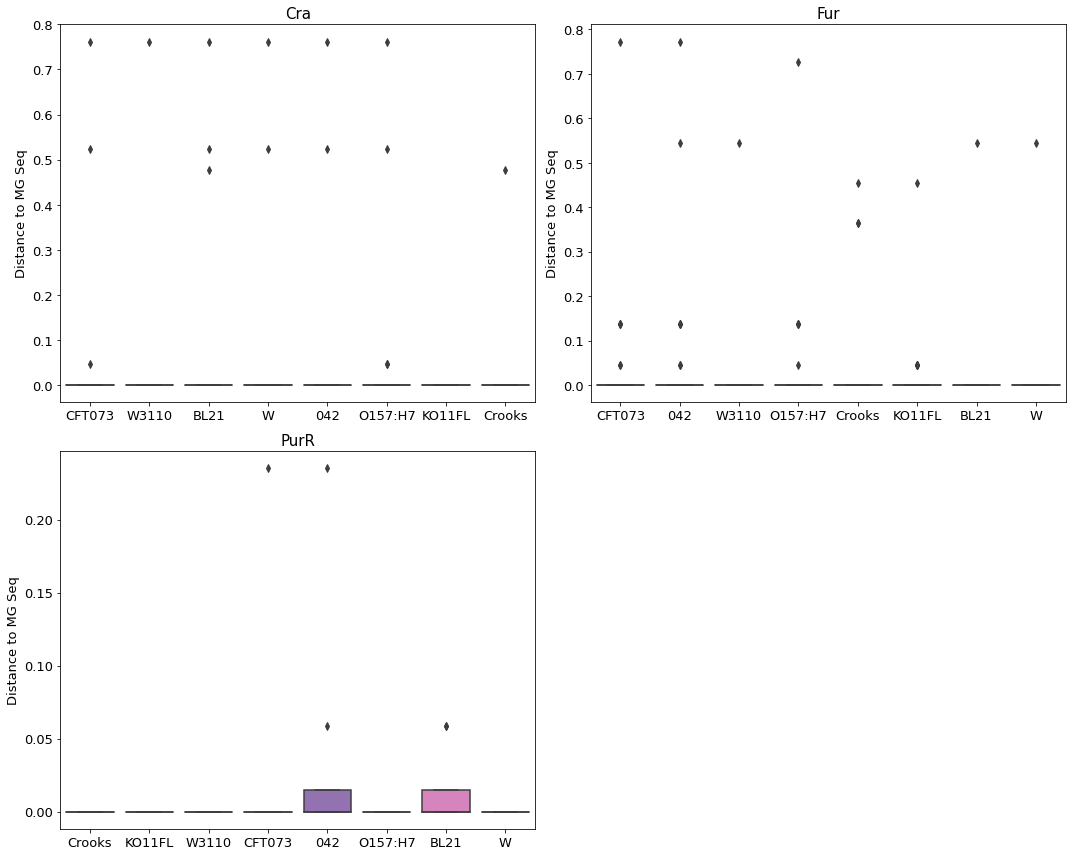

In [66]:
_, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()

tfbs_match_dfs = []

for ax, (tf, tf_tfbs_multistrain_df) in zip(axs, tfbs_multistrain_df.groupby('tf')):
    
    match_dfs = []
    
    for (mg_tu_id, mg_tfbs_id), mg_tfbs_multistrain_df in tf_tfbs_multistrain_df.groupby(
        ['mg_tu_id', 'mg_tfbs_id']):
        
        # we have the multistrain equivalents for a single TFBS based on the RegulonDB location; 
        # but we just want to keep the ones where the multistrain scores are comparable to the MG score,
        # an indicator that a similar strength motif has been found
        # AND also only use this match row if the RDB and MotifSearch TSS dists are the same
        rdb_row = mg_tfbs_multistrain_df[mg_tfbs_multistrain_df['source'] == 'RegulonDB'].T.squeeze()
        mg_search_row = mg_tfbs_multistrain_df[
            (mg_tfbs_multistrain_df['source'] == 'MotifSearch') &
            (mg_tfbs_multistrain_df['strain_name'] == 'MG1655')
        ].T.squeeze()
        multistrain_rows = mg_tfbs_multistrain_df[mg_tfbs_multistrain_df['strain_name'] != 'MG1655']
        
        if mg_search_row.tss_dist - 5 < rdb_row.tss_dist < mg_search_row.tss_dist + 5:
            
            # take the multistrain matches with scores similar to MG
            multistrain_rows_match = multistrain_rows[
                multistrain_rows['tfbs_score'] >= (mg_search_row.tfbs_score - 2)
            ].copy()
            if not multistrain_rows_match.empty:
                def dist_to_mg(strain_seq):
                    return hamming(list(mg_search_row.tfbs_seq), list(strain_seq))
                multistrain_rows_match['dist_to_mg'] = multistrain_rows_match['tfbs_seq'].apply(dist_to_mg)
                match_dfs.append(multistrain_rows_match)
    
    tf_tfbs_match_df = pd.concat(match_dfs)
    tfbs_match_dfs.append(tf_tfbs_match_df)
    
    sns.boxplot(x='strain_name', y='dist_to_mg', data=tf_tfbs_match_df, ax=ax)
    ax.set_title(f'{tf}', fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('Distance to MG Seq', fontsize=13)
    ax.tick_params(axis='both', labelsize=13)
    
axs[-1].set_visible(False)
    
plt.tight_layout()

tfbs_match_df = pd.concat(tfbs_match_dfs)

## Specific TFBS Deeper Look

In [85]:
for (mg_tu_id, mg_tfbs_id), tu_tfbs_match_df in tfbs_match_df.groupby(['mg_tu_id', 'mg_tfbs_id']):
    if tu_tfbs_match_df['dist_to_mg'].sum() > 0:
        mg_row = tfbs_multistrain_df[
            (tfbs_multistrain_df['mg_tu_id'] == mg_tu_id) &
            (tfbs_multistrain_df['mg_tfbs_id'] == mg_tfbs_id) & 
            (tfbs_multistrain_df['strain_name'] == 'MG1655') & 
            (tfbs_multistrain_df['source'] == 'MotifSearch')
        ].T.squeeze()
        
        # make multi_alignment
        seq_recs = []
        for row in tu_tfbs_match_df.itertuples():
            seq_rec = SeqRecord(Seq(row.tfbs_seq),
                                id=f'{row.strain_name} | {int(row.tss_dist)} | {row.tfbs_score:.2f}')
            seq_recs.append(seq_rec)
        seq_recs.append(SeqRecord(Seq(mg_row.tfbs_seq),
                                  id=f'{mg_row.strain_name} | {int(mg_row.tss_dist)} | {mg_row.tfbs_score:.2f}'))
        msa = MultipleSeqAlignment(seq_recs)
        
        tf = tu_tfbs_match_df['tf'].unique()[0]
        tu_name = mega_clean_tu_table.loc[mg_tu_id].T.squeeze()['name']

        print(f'Multistrain {tf} binding sites for MG1655 TU {tu_name}')
        print()
        print(msa)
        print()

Multistrain Fur binding sites for MG1655 TU nrdHIEF

Alignment with 9 rows and 22 columns
GCGTAATCAATCTAAAATTCCC CFT073 | -60 | -2.40
GCGTAATCAATCTAAAATTCCC 042 | -60 | -2.40
CCAGGGTAATTTCGACCACTAT W3110 | -65 | -2.10
AAATTACCATATCTTGTGTGGT O157:H7 | -46 | -2.90
CGATGAAAATCACGATTTCTTT Crooks | -79 | -0.10
CGATGAAAATCACGATTTCTTT KO11FL | -79 | -0.10
CCAGGGTAATTTCGACCACTAT BL21 | -65 | -2.10
CCAGGGTAATTTCGACCACTAT W | -65 | -2.10
CCAGGGTAATTTCGACCACTAT MG1655 | -65 | -2.10

Multistrain Fur binding sites for MG1655 TU exbD

Alignment with 7 rows and 22 columns
TCACAATGATGCCCGGTTGCTT 042 | -24 | -2.70
TCACAATGATGCCCGGTTGCTT W3110 | -24 | -2.70
TAGCAACGGCAATCGGCCTCGT Crooks | -49 | -3.40
TAGCAACGGCAATCGGCCTCGT KO11FL | -49 | -3.40
TCACAATGATGCCCGGTTGCTT BL21 | -24 | -2.70
TCACAATGATGCCCGGTTGCTT W | -24 | -2.70
TAGCAACGGCAATCGGCCTCGT MG1655 | -48 | -3.40

Multistrain PurR binding sites for MG1655 TU pyrD

Alignment with 7 rows and 17 columns
AAGAAAACGTTTGCTAT CFT073 | -57 | 9.50
AAGAAAACGTTT

# Next Steps

## 1/19/21

- be more stringent in aligning expected locations of binding sites before motif search in multi strain
- focus on Fur, Cra, PurR
- send update to senior design team